In [1]:
#
# Computing diffusion coeff and exponent alpha from individual msd
#

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from os import listdir
import pickle
#from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import brunnermunzel, linregress
from sklearn.linear_model import LinearRegression

In [292]:
#
# read csv files
#

file_id = 'SK668-No3-6-2'

df = pd.read_csv(os.path.join('data', file_id + '.csv'))

dir_save = 'results_' + file_id
dir_save = dir_save.replace('-', '_')
print(dir_save)
os.makedirs(dir_save, exist_ok=True)
#print(df)
#print(df2)
#df['m0'] = df2['m0']
print(df)
n_traj = df['Trajectory'].max()
print('# of trajectories: ', n_traj)

results_SK668_No3_6_2
              Trajectory  Frame        x         y  z     m0     m1     m2  \
0          1           1      0  207.519    22.410  0  0.178  1.405  2.446   
1          2           1      1  206.801    23.309  0  0.160  1.366  2.347   
2          3           1      2  206.696    23.833  0  0.150  1.299  2.125   
3          4           1      3  206.748    23.784  0  0.168  1.338  2.268   
4          5           2      0  144.348    61.324  0  0.520  1.308  2.169   
...      ...         ...    ...      ...       ... ..    ...    ...    ...   
45470  45471        4338    100  612.650  1103.403  0  0.181  1.453  2.675   
45471  45472        4339     99  379.322  1109.758  0  0.200  1.521  2.892   
45472  45473        4339    100  375.537  1110.184  0  0.271  1.559  3.005   
45473  45474        4340     99  617.758  1150.009  0  0.238  1.313  2.149   
45474  45475        4340    100  617.363  1149.828  0  0.201  1.250  1.975   

          m3      m4  NPscore  
0      4.

0  th traj length =  4
1  th traj length =  84
2  th traj length =  3
3  th traj length =  39
4  th traj length =  101
5  th traj length =  31
6  th traj length =  101
7  th traj length =  14
8  th traj length =  3
9  th traj length =  101


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

0.2670830996588082


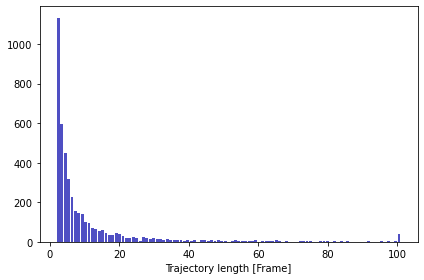

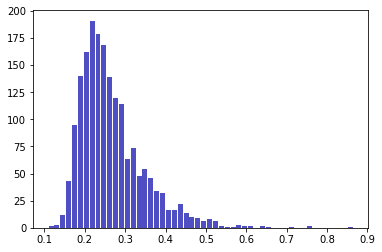

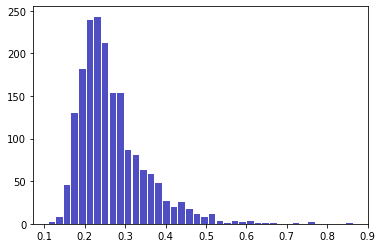

In [293]:
#
# basic characterization
#
lengths = []
m0s = []
for n in range(n_traj):
    df2 = df.loc[df['Trajectory'] == n+1]
    lengths.append(df2.shape[0])
    if n < 10:
        print(n, ' th traj length = ', df2.shape[0])
    if df2.shape[0] > 5:
        m0s.append(df2['m0'].mean())

lengths = np.array(lengths)
m0s = np.array(m0s)
print(np.mean(m0s))

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=lengths, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Trajectory length [Frame]')
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'hist_traj_length.eps'))

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=m0s, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=m0s[m0s[:] < 20000], bins=40, color='#0504aa', alpha=0.7, rwidth=0.85)

(31,) (31,)
(31, 2)


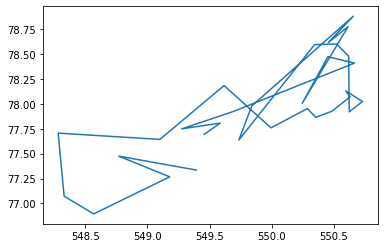

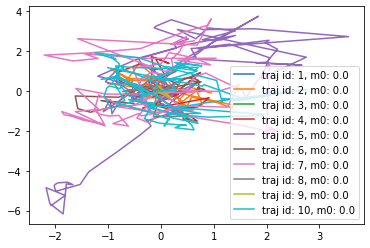

In [294]:
#
# data visualization
#
def select_single_trajectory(df, id_traj = 1, verbosity=1):
    df2 = df.loc[df['Trajectory'] == id_traj]
    #if id_cell == 1: print(df2)# for debug
    coord_x = df2['x'].to_numpy()
    coord_y = df2['y'].to_numpy()
    if verbosity == 1:
        print(coord_x.shape, coord_y.shape)
    return np.stack([coord_x, coord_y], axis=-1)

def compute_total_intensity(df, id_traj = 1):
    df2 = df.loc[df['Trajectory'] == id_traj]
    return df2['m0'].mean()

xy = select_single_trajectory(df, 6)
print(xy.shape)
fig, ax = plt.subplots()
plt.plot(xy[:, 0], xy[:, 1])

fig, ax = plt.subplots()
for n in range(10):
    xy = select_single_trajectory(df, n+1, verbosity=0)
    m0 = compute_total_intensity(df, n+1)
    mean_xy = np.mean(xy, axis=0)
    label = 'traj id: ' + str(n+1) + ', m0: ' + str(np.round(m0))
    plt.plot(xy[:, 0] - mean_xy[0], xy[:, 1] - mean_xy[1], label=label)
plt.legend()

len(msds) =  1174


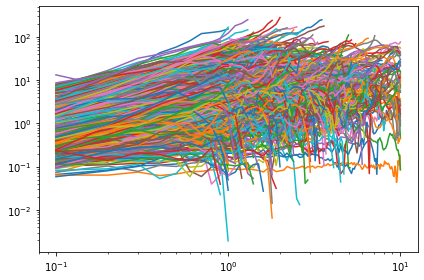

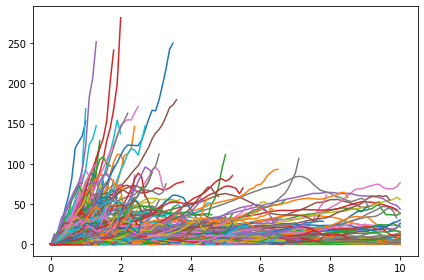

In [295]:
#
# MSD analysis
#
def naive_msd(r):
    shifts = np.arange(len(r))
    msd = np.zeros(shifts.size)

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None, :] - r[shift:, :]# if shift == 0, r[:None, :] not r[None, :]
        sqdist = np.square(diffs).sum(axis=1)
        msd[i] = sqdist.mean()

    return msd

msds = []
for n in range(n_traj):
    xy = select_single_trajectory(df, n+1, verbosity=0)
    if xy.shape[0] >= 10:
        #disp = (xy - xy[0, :])[1:]
        msd = naive_msd(xy)
        msds.append(msd)
print('len(msds) = ', len(msds))
num_msd = len(msds)

with open(os.path.join(dir_save, 'msds'), 'wb') as fp:
    pickle.dump(msds, fp)

fig, ax = plt.subplots()
for msd in msds:
    ts = 0.1 * np.arange(msd.shape[0])
    plt.loglog(ts[1:], msd[1:])
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'msds_log.eps'))

fig, ax = plt.subplots()
for msd in msds:
    ts = 0.1 * np.arange(msd.shape[0])
    plt.plot(ts, msd)
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'msds_normal.eps'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

0.08374266797113557
1174


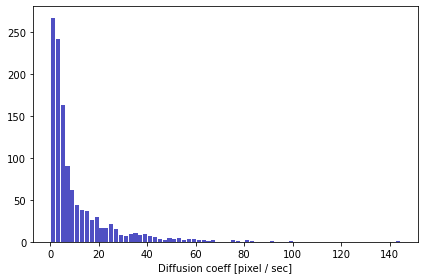

In [296]:
#
# individual diffusion coeffs assuming normal diffusion, following the protocol in (Delarue, Cell, 2018)
#
diffs = []
for msd in msds:
    msd_trunc = msd[:10]
    ts = 0.1 * np.arange(msd_trunc.shape[0])
    reg = LinearRegression(fit_intercept=False).fit(ts.reshape(-1, 1), msd_trunc)
    #print(reg.coef_)
    #res = linregress(ts, msd_trunc) # for comparison
    #print(res.slope)
    diffs.append(reg.coef_[0])

diffs = np.array(diffs)
fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=diffs, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Diffusion coeff [pixel / sec]')
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'hist_diff_coeff.eps'))

Deff = (diffs/4)*0.26*0.26 # Deff(pixel/sec)からDeff(um^2/sec)へ変換
print(np.median(Deff)) 
print(np.count_nonzero(Deff))

np.savetxt(os.path.join(dir_save, 'Deff.txt'), Deff)

      0         1         2         3          4          5          6    \
0     0.0  0.197419  0.358891  0.536893   0.676937   0.778890   0.874846   
1     0.0  0.260021  0.506301  0.805377   1.076860   1.294941   1.515322   
2     0.0  0.904432  1.826187  2.241763   2.577368   2.887036   2.963975   
3     0.0  0.314929  0.584769  0.818716   0.963876   1.087199   1.339288   
4     0.0  0.628895  1.144985  1.727100   2.216709   2.517523   2.690410   
...   ...       ...       ...       ...        ...        ...        ...   
1169  0.0  1.374741  4.330264  7.403674  10.445687  14.702370  16.751076   
1170  0.0  0.485317  0.981398  1.898072   3.122062   4.876670   6.331603   
1171  0.0  0.341245  0.865750  1.188396   1.000755   0.974814   1.000289   
1172  0.0  0.217433  0.473871  0.828294   1.121920   1.688036   2.363063   
1173  0.0  0.234991  0.139364  0.209583   0.192180   0.154211   0.139377   

            7          8          9    ...        91         92         93   \
0      0

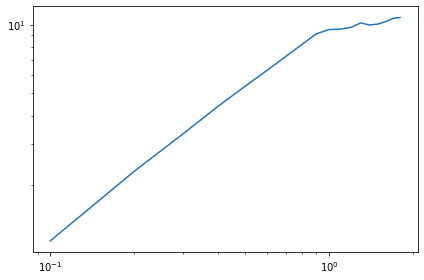

In [297]:
#
# Ensemble-averaged MSD
#
#for msd in msds:
#    print(msd.shape)
df_msds = pd.DataFrame(msds)
print(df_msds)
ens_msd = df_msds.mean(0, skipna=True).values
print(ens_msd)

fig, ax = plt.subplots()
ts = 0.1 * np.arange(ens_msd.shape[0])
plt.loglog(ts[1:19], ens_msd[1:19])
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'ens_msd_log.eps'))

res = linregress(np.log(ts[1:11]), np.log(ens_msd[1:11])) # for comparison
print(res, res.slope)

np.savetxt(os.path.join(dir_save, 'ens_msd.txt'), ens_msd)